In [1]:
import timm
import torch
from torch import Tensor
import torch.nn as nn
from PIL import Image
from typing import Optional, Callable, Any, Tuple, Union, Literal, List
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import plenoptic as po
import torch
import numpy as np
from plenoptic.tools.display import clean_up_axes
from functools import partial
from torchvision import transforms

import matplotlib.pyplot as plt
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

# needed for the plotting/animating:
%matplotlib inline
plt.rcParams["animation.html"] = "html5"
# use single-threaded ffmpeg for animation writer
plt.rcParams["animation.writer"] = "ffmpeg"
plt.rcParams["animation.ffmpeg_args"] = ["-threads", "1"]

In [ ]:
# Load from Huggingface Hub
model = timm.create_model("hf-hub:nateraw/resnet50-oxford-iiit-pet", pretrained=True)

# Set model to eval mode for inference
model.eval()

# Create Transform
transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))

In [3]:
type(transform)

torchvision.transforms.transforms.Compose

In [4]:
resolve_data_config(model.pretrained_cfg, model=model)

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.95,
 'crop_mode': 'center'}

torch.Size([1, 3, 256, 256])


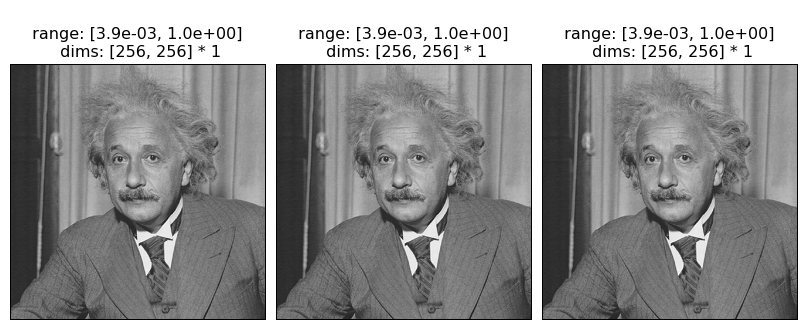

In [5]:
img = po.data.einstein().to(0)
img = img.repeat(1, 3, 1, 1)
print(img.shape)
po.imshow(img);

In [6]:
img_resnet_ready = transform(img)

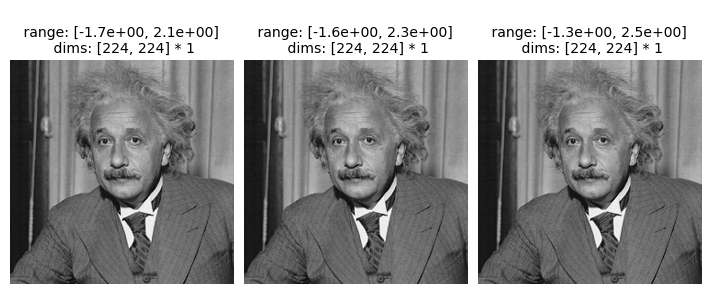

In [7]:
po.imshow(img_resnet_ready);

In [8]:
train_nodes, eval_nodes = get_graph_node_names(model)

In [9]:
eval_nodes

['x',
 'conv1',
 'bn1',
 'act1',
 'maxpool',
 'layer1.0.conv1',
 'layer1.0.bn1',
 'layer1.0.act1',
 'layer1.0.conv2',
 'layer1.0.bn2',
 'layer1.0.drop_block',
 'layer1.0.act2',
 'layer1.0.aa',
 'layer1.0.conv3',
 'layer1.0.bn3',
 'layer1.0.downsample.0',
 'layer1.0.downsample.1',
 'layer1.0.add',
 'layer1.0.act3',
 'layer1.1.conv1',
 'layer1.1.bn1',
 'layer1.1.act1',
 'layer1.1.conv2',
 'layer1.1.bn2',
 'layer1.1.drop_block',
 'layer1.1.act2',
 'layer1.1.aa',
 'layer1.1.conv3',
 'layer1.1.bn3',
 'layer1.1.add',
 'layer1.1.act3',
 'layer1.2.conv1',
 'layer1.2.bn1',
 'layer1.2.act1',
 'layer1.2.conv2',
 'layer1.2.bn2',
 'layer1.2.drop_block',
 'layer1.2.act2',
 'layer1.2.aa',
 'layer1.2.conv3',
 'layer1.2.bn3',
 'layer1.2.add',
 'layer1.2.act3',
 'layer2.0.conv1',
 'layer2.0.bn1',
 'layer2.0.act1',
 'layer2.0.conv2',
 'layer2.0.bn2',
 'layer2.0.drop_block',
 'layer2.0.act2',
 'layer2.0.aa',
 'layer2.0.conv3',
 'layer2.0.bn3',
 'layer2.0.downsample.0',
 'layer2.0.downsample.1',
 'layer2.0

In [10]:
class IntermediateOutputResnet(nn.Module):
    def __init__(self, model: nn.Module, return_node: str, transform: Optional[Callable] = None):
        super().__init__()
        self.return_node = return_node
        self.extractor = create_feature_extractor(model, return_nodes=[return_node])
        self.model = model
        self.transform = transform

    def forward(self, x):
        if self.transform is not None:
            x = self.transform(x)
        return self.extractor(x)[self.return_node]

    def plot_representation(
        self,
        data: Tensor,
        ax: Optional[plt.Axes] = None,
        figsize: Tuple[float, float] = (15, 15),
        ylim: Optional[Union[Tuple[float, float], Literal[False]]] = None,
        batch_idx: int = 0,
        title: Optional[str] = None,
    ) -> Tuple[plt.Figure, List[plt.Axes]]:
        # Select the batch index
        data = data[batch_idx]

        # Compute across channels spatal error
        spatial_error = torch.abs(data).mean(dim=0).detach().cpu().numpy()

        # Compute per-channel error
        error = torch.abs(data).mean(dim=(1, 2))  # Shape: (C,)
        sorted_idx = torch.argsort(error, descending=True)
        sorted_error = error[sorted_idx].detach().cpu().numpy()

        # Determine figure layout
        if ax is None:
            fig, axes = plt.subplots(2, 1, figsize=figsize, gridspec_kw={"height_ratios": [1, 1]})
        else:
            ax = clean_up_axes(ax, False, ["top", "right", "bottom", "left"], ["x", "y"])
            gs = ax.get_subplotspec().subgridspec(2, 1, height_ratios=[3, 1])
            fig = ax.figure
            axes = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]

        # Plot average error across channels
        po.imshow(
            ax=axes[0], image=spatial_error[None, None, ...], title="Average Error Across Channels", vrange="auto0"
        )
        # axes[0].set_title()

        # Plot channel error distribution
        x_pos = np.arange(20)
        axes[1].bar(x_pos, sorted_error[:20], color="C1", alpha=0.7)
        axes[1].set_xticks(x_pos)
        axes[1].set_xticklabels(sorted_idx[:20].tolist(), rotation=45)
        axes[1].set_xlabel("Channel")
        axes[1].set_ylabel("Absolute error")
        axes[1].set_title("Top 20 Channels Contributions to Error")

        if title is not None:
            fig.suptitle(title)

        return fig, axes

In [11]:
test_model = IntermediateOutputResnet(model, "layer2", transform)
test_model.to(0);

In [ ]:
po.tools.remove_grad(test_model)

test_model.eval()

po.tools.validate.validate_model(test_model, device=0, image_shape=(1, 3, 224, 224))

In [13]:
test_model(img.to(0)).shape

torch.Size([1, 512, 28, 28])

In [14]:
def low_pass_gaussian(img, kernel_size=11, sigma=5):
    """Applies a Gaussian blur to low-pass filter the image."""
    blur = transforms.GaussianBlur(kernel_size=kernel_size, sigma=sigma)
    return blur(img)


met = po.synth.Metamer(
    img,
    test_model,
    # initial_image=low_pass_gaussian(img)
)
optim = torch.optim.Adam([met.metamer], lr=1e-3)

To synthesize the model metamer, we use the synthesize method. Setting the `store_progress` arg stores copies of the model metamer over time, which will allow us to visualize synthesis progress after the fact:

In [ ]:
met.synthesize(
    3000,
    store_progress=10,
    optimizer=optim,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

The plot on the left shows the model metamer, the middle plot shows the synthesis loss, and the plot on the left shows the model representation error:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0010479073..1.0009503].
/opt/conda/lib/python3.11/site-packages/plenoptic/tools/display.py:927: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


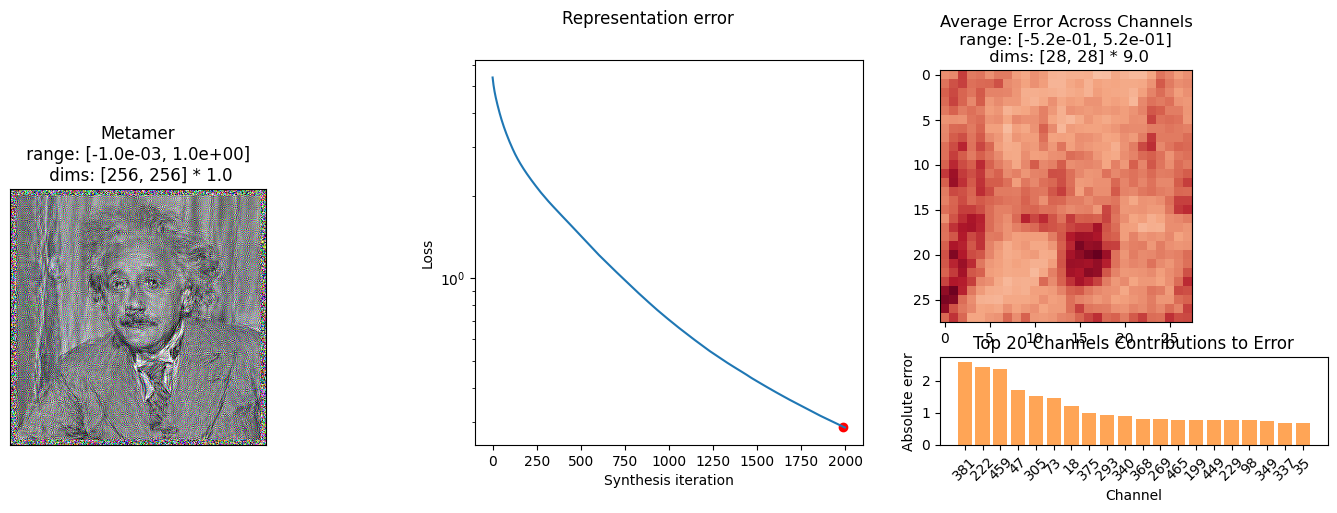

In [17]:
po.synth.metamer.plot_synthesis_status(met, ylim=False, iteration=-10);

We can also plot the images and their representation directly:

In [18]:
test_model(img).shape

torch.Size([1, 512, 28, 28])

In [32]:
img.shape

torch.Size([1, 3, 256, 256])

We can also automate that synthesis status plot, to see the metamer being created:

/opt/conda/lib/python3.11/site-packages/plenoptic/tools/display.py:927: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")
/opt/conda/lib/python3.11/site-packages/plenoptic/synthesize/metamer.py:1653: UserWarning: Looks like representation is image-like, haven't fully thought out how to best handle rescaling color ranges yet!
  warnings.warn("Looks like representation is image-like, haven't fully thought out how"


Exception: data has 512 things to plot, but you passed 3 axes , so unsure how to continue!

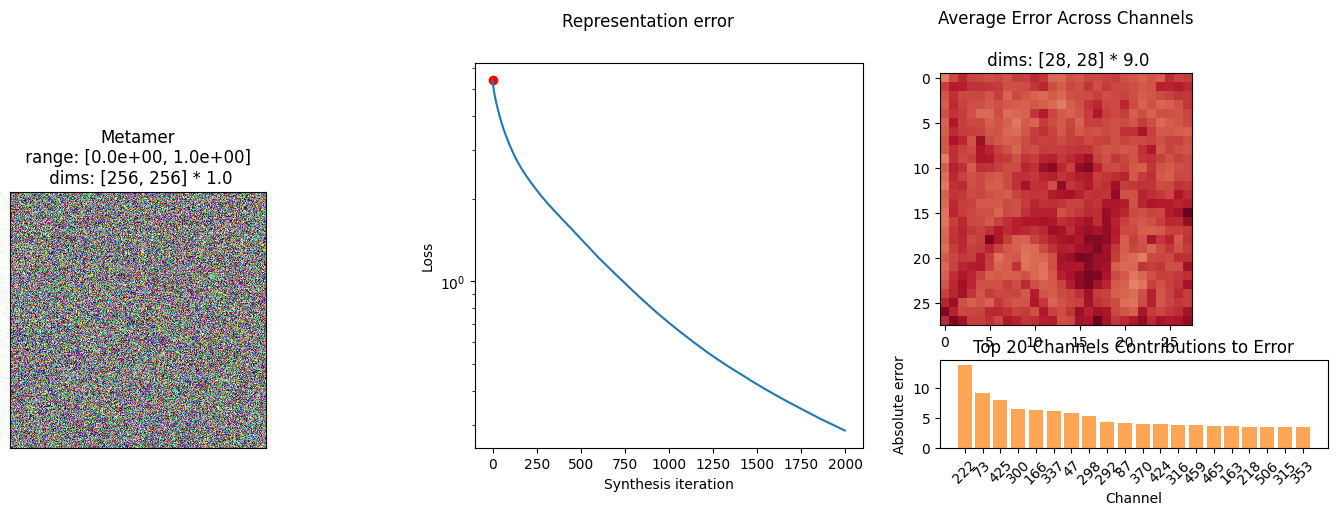

In [36]:
po.synth.metamer.animate(met, ylim=False)